## Contents:
- [Imports](#Imports)
- [Load Data from AWS and prepare](#Load-Data-from-AWS-and-prepare)
- [Cluster Location Data](#Clustered-Location-Data)
- [Explore Target Variable Transformations](#Explore-Target-Variable-Log-Transform)
- [Model #1, OLS, not scaled. As baseline for regression.](#Model-#1,-OLS,-not-scaled.-As-baseline-for-regression.)
- [Model #2, Statsmodel for stastical significance testing](#Model-#2,-Statsmodel-for-stastical-significance-testing)
- [Model #3, Linear Regression, scaled](#Model-#3,-Linear-Regression,-scaled)
- [Model #4, Lasso Gridsearch, basic](#Model-#4,-Lasso-Gridsearch,-basic)
- [Model #5, Ridge Gridsearch, L1 penalty is not kind to our model. Trying L2.](#Model-#5,-RidgeCV,-L1-penalty-is-not-kind-to-our-model.-Trying-L2.)
- [Model #6, Elastic Search Gridsearch, Exploring Polynomial Features](#Model-#6,-Elastic-Search-Gridsearch,-Exploring-Polynomial-Features)

This notebook explores various transformations and approaches while using linear regression models. The goal of this notebook is not to produce the best performing model, but to explore techniques that may be useful in later notebooks to boost the model score and to evaluate feature importance. Ultimately, this project chooses to frame the problem as a classification instead of regression problem. From the first niave model to final model tested in this notebook with scaling, L2 regularization, feature variable log transformation, and polynomial features added there is an increase in R^2 is .005 to .13. 

#### Techniques and models explored:

|Model|R^2 Score|Technique Applied|
|---|---|---|
|Ordinary Least Squares|.005|Niave|
|Ordinary Least Squares|.124|Log Transform|
|Ordinary Least Squares|.121|Log Transform + Standard Scalar|
|Lasso Regression|.004|L1 penalty|
|Lasso Regression|.121|Log transform + L1 penalty|
|Ridge Regression|.121|Log transform + L2 penalty|
|Elastic Search|.134|Log transform + L2 penalty + polynomial features|

# Imports

In [1]:
#from google.colab import drive 
import pandas as pd
import numpy as np

# standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# modeling imports
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV,ElasticNetCV, ElasticNet
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn import metrics
import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')

#set_style
plt.style.use('fivethirtyeight')

%config InlineBackend.figure_format = 'retina'

# Load Data from AWS and prepare

### Load

#### Read cleaned dataset from AWS

In [2]:
model_df = pd.read_csv('s3://git-to-amazon-s3-outputbucket-rorni8oehk4l/soulclimberchick/meteorology-fire-impact/data-files/mfi_df_yr_trail.csv')
model_df.dropna(inplace=True)
# model_df = pd.read_csv('./data/mfi_df_yr_latlong.csv')

model_df.drop(columns='Unnamed: 0', inplace=True)

In [3]:
# Most wildfires are class A and B or under 100 acres
model_df['fire_size_class'].value_counts(normalize = True)

A    0.615586
B    0.272828
C    0.059007
D    0.017875
E    0.014640
F    0.012505
G    0.007558
Name: fire_size_class, dtype: float64

In [4]:
model_df.head(3)

,fire_code,fire_name,complex_name,stat_cause_code,stat_cause_descr,fire_size,fire_size_class,latitude,longitude,state,...,pcp_t9m,pcp_t12m,pmdi_t3m,pmdi_t6m,pmdi_t9m,pmdi_t12m,pdsi_t3m,pdsi_t6m,pdsi_t9m,pdsi_t12m
3469,C781,PACIFIC,NO_NAME,5.0,Debris Burning,0.1,A,32.7167,-114.5008,AZ,...,1.332222,1.5125,2.73,3.62,3.715556,3.203333,3.463333,4.101667,4.036667,3.444167
3470,C428,SANTEFEGAS,NO_NAME,13.0,Missing/Undefined,5.0,B,33.2000,-112.5340,AZ,...,1.332222,1.5125,2.73,3.62,3.715556,3.203333,3.463333,4.101667,4.036667,3.444167
3474,C426,JOSHUATREE,NO_NAME,9.0,Miscellaneous,0.1,A,33.8667,-112.3841,AZ,...,1.872222,1.8375,3.95,3.89,4.140000,3.655833,4.393333,4.371667,4.461111,3.896667


## Prepare

# Cluster Location Data

In [5]:
# Put lat/long into a matrix
location_data = round(model_df[['longitude', 'latitude']],4) # round to decrease grid accuracy of lat/long

# Cluster lat/long
km = KMeans(n_clusters=200)
km.fit(location_data)

# Append clusters back into model_df
model_df.loc[:, 'cluster'] = km.predict(location_data)

#### Explore model_df['month] as a one hot encode feature

In [6]:
model_df = pd.get_dummies(model_df, columns=['month'], drop_first=True) # in relation to January
model_df = pd.get_dummies(model_df, columns=['cluster']) # location clustered by lat/long

### Normal

In [7]:
#create X and y variables
X = model_df[[ 'pcp', 'tavg', 'pdsi', 'phdi', 'zndx', 'pmdi', 'sp02',
       'sp03', 'sp06', 'sp09', 'sp12', 'sp24', 'tmin', 'tmax', 'month_2', 'month_3',
       'month_4', 'month_5', 'cdd', 'hdd','month_6', 'month_7', 'month_8', 'month_9',
       'month_10', 'month_11', 'month_12', 'cluster_0', 'cluster_1', 'cluster_2',
       'cluster_3', 'cluster_4', 'cluster_5', 'cluster_6', 
       'cluster_7', 'cluster_8', 'cluster_9', 'cluster_10', 'cluster_11',
       'cluster_12', 'cluster_13', 'cluster_14', 'cluster_15', 'cluster_16',
       'cluster_17', 'cluster_18', 'cluster_19', 'cluster_20', 'cluster_21',
       'cluster_22', 'cluster_23', 'cluster_24', 'cluster_25', 'cluster_26',
       'cluster_27', 'cluster_28', 'cluster_29', 'cluster_30', 'cluster_31',
       'cluster_32', 'cluster_33', 'cluster_34', 'cluster_35', 'cluster_36',
       'cluster_37', 'cluster_38', 'cluster_39', 'cluster_40', 'cluster_41',
       'cluster_42', 'cluster_43', 'cluster_44', 'cluster_45', 'cluster_46',
       'cluster_47', 'cluster_48', 'cluster_49', 'cluster_50', 'cluster_51',
       'cluster_52', 'cluster_53', 'cluster_54', 'cluster_55', 'cluster_56',
       'cluster_57', 'cluster_58', 'cluster_59', 'cluster_60', 'cluster_61',
       'cluster_62', 'cluster_63', 'cluster_64', 'cluster_65', 'cluster_66',
       'cluster_67', 'cluster_68', 'cluster_69', 'cluster_70', 'cluster_71',
       'cluster_72', 'cluster_73', 'cluster_74', 'cluster_75', 'cluster_76',
       'cluster_77', 'cluster_78', 'cluster_79', 'cluster_80', 'cluster_81',
       'cluster_82', 'cluster_83', 'cluster_84', 'cluster_85', 'cluster_86',
       'cluster_87', 'cluster_88', 'cluster_89', 'cluster_90', 'cluster_91',
       'cluster_92', 'cluster_93', 'cluster_94', 'cluster_95', 'cluster_96',
       'cluster_97', 'cluster_98', 'cluster_99', 'cluster_100', 'cluster_101',
       'cluster_102', 'cluster_103', 'cluster_104', 'cluster_105',
       'cluster_106', 'cluster_107', 'cluster_108', 'cluster_109',
       'cluster_110', 'cluster_111', 'cluster_112', 'cluster_113',
       'cluster_114', 'cluster_115', 'cluster_116', 'cluster_117',
       'cluster_118', 'cluster_119', 'cluster_120', 'cluster_121',
       'cluster_122', 'cluster_123', 'cluster_124', 'cluster_125',
       'cluster_126', 'cluster_127', 'cluster_128', 'cluster_129',
       'cluster_130', 'cluster_131', 'cluster_132', 'cluster_133',
       'cluster_134', 'cluster_135', 'cluster_136', 'cluster_137',
       'cluster_138', 'cluster_139', 'cluster_140', 'cluster_141',
       'cluster_142', 'cluster_143', 'cluster_144', 'cluster_145',
       'cluster_146', 'cluster_147', 'cluster_148', 'cluster_149',
       'cluster_150', 'cluster_151', 'cluster_152', 'cluster_153',
       'cluster_154', 'cluster_155', 'cluster_156', 'cluster_157',
       'cluster_158', 'cluster_159', 'cluster_160', 'cluster_161',
       'cluster_162', 'cluster_163', 'cluster_164', 'cluster_165',
       'cluster_166', 'cluster_167', 'cluster_168', 'cluster_169',
       'cluster_170', 'cluster_171', 'cluster_172', 'cluster_173',
       'cluster_174', 'cluster_175', 'cluster_176', 'cluster_177',
       'cluster_178', 'cluster_179', 'cluster_180', 'cluster_181',
       'cluster_182', 'cluster_183', 'cluster_184', 'cluster_185',
       'cluster_186', 'cluster_187', 'cluster_188', 'cluster_189',
       'cluster_190', 'cluster_191', 'cluster_192', 'cluster_193',
       'cluster_194', 'cluster_195', 'cluster_196', 'cluster_197',
       'cluster_198', 'cluster_199',
             'tavg_t12m',
       'tavg_t9m', 'tavg_t6m', 'tavg_t3m', 'pcp_t12m', 'pcp_t9m', 'pcp_t6m',
       'pcp_t3m', 'pmdi_t12m', 'pmdi_t9m', 'pmdi_t6m', 'pmdi_t3m', 'pdsi_t12m',
       'pdsi_t9m', 'pdsi_t6m', 'pdsi_t3m']]
y = model_df[['fire_size']]

assert len(X) == len(y)

In [8]:
#split into training and test groups
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size=.2, train_size = .8)

# Explore Target Variable Log Transform

In [9]:
#try a log on it
model_df['fire_size_log'] = np.log(model_df['fire_size'])

#log +1
model_df['fire_size_log1'] = np.log(model_df['fire_size']+1)

#log +1 normalized

#normalize function
def normalize(column):
    upper = column.max()
    lower = column.min()
    y = (column - lower)/(upper-lower)
    return y

model_df['fire_size_log1_norm'] = normalize(model_df['fire_size_log1'])

#cube root
model_df['fire_size_cubert'] = (model_df['fire_size']**(1/3))

#log max root
log_max = np.log(model_df['fire_size'].max())
model_df['fire_size_logmax'] = model_df['fire_size']**(1/log_max)

In [10]:
#taking the inverse of function of log(price) to convert log(price) back to fire_size
model_df['fire_size_log_to_norm'] = np.exp(model_df['fire_size_log'])
model_df[['fire_size_log', 'fire_size_log_to_norm','fire_size']]

,fire_size_log,fire_size_log_to_norm,fire_size
3469,-2.302585,0.1,0.1
3470,1.609438,5.0,5.0
3474,-2.302585,0.1,0.1
3477,-2.302585,0.1,0.1
3589,1.098612,3.0,3.0
...,...,...,...
420158,-2.302585,0.1,0.1
420159,-2.302585,0.1,0.1
420160,-2.302585,0.1,0.1
420165,3.465736,32.0,32.0


A visual look of effect of the transformations on distribution. Log transform gives the closest apperance to a normal distribution. Let's see how it compares when modeled.

#### No transformation

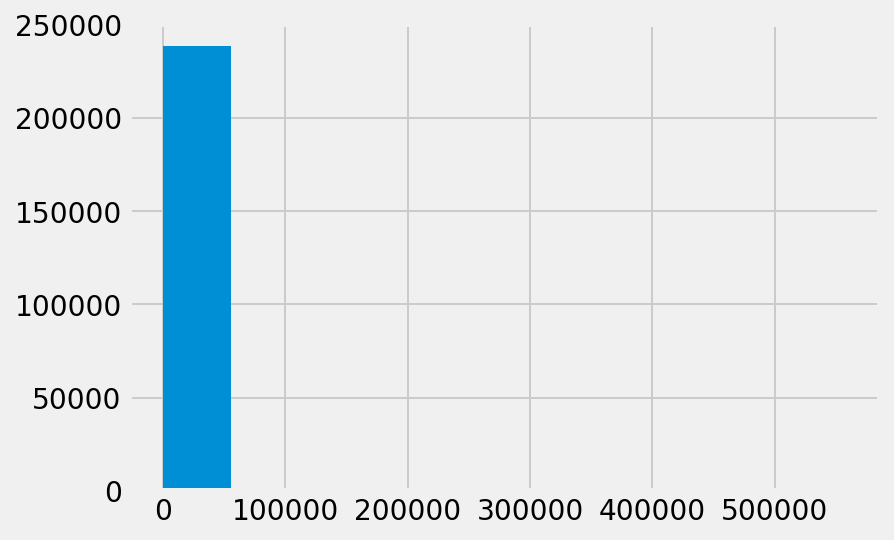

In [11]:
model_df['fire_size'].hist();

#### Log Transform

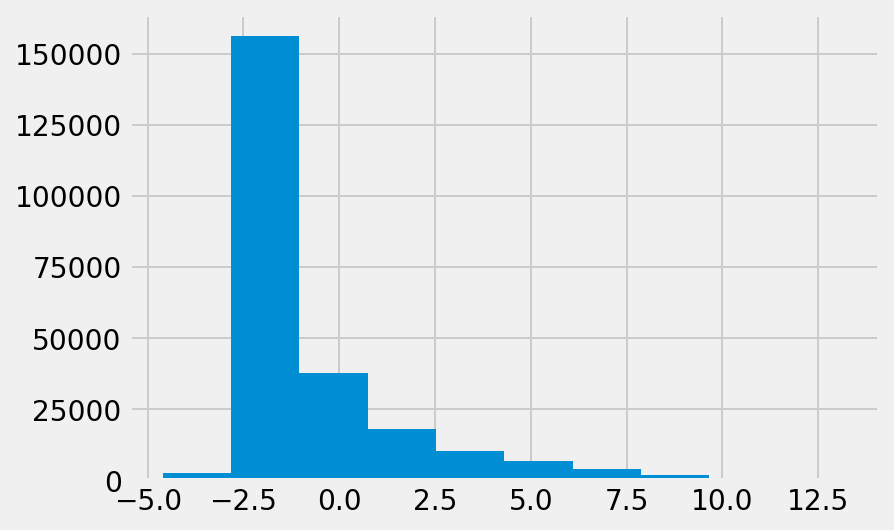

In [12]:
model_df['fire_size_log'].hist();

#### Log +1

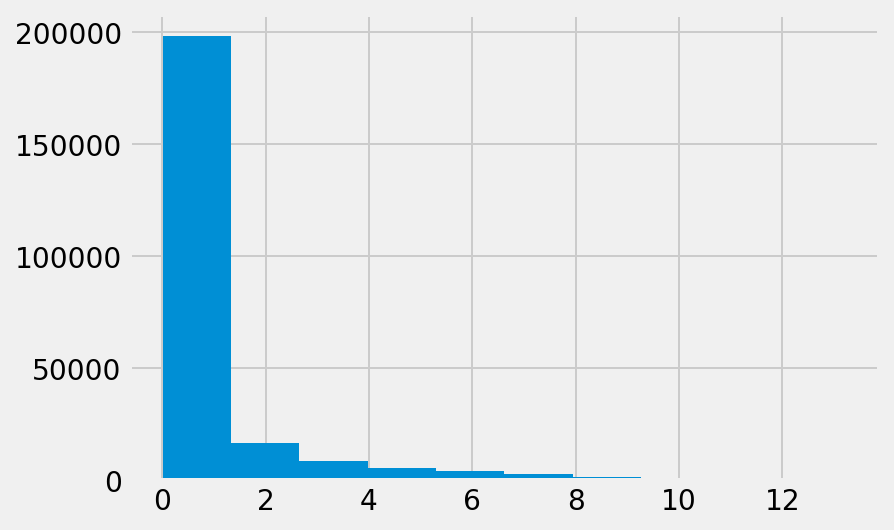

In [13]:
model_df['fire_size_log1'].hist();

#### Log 1 normalized

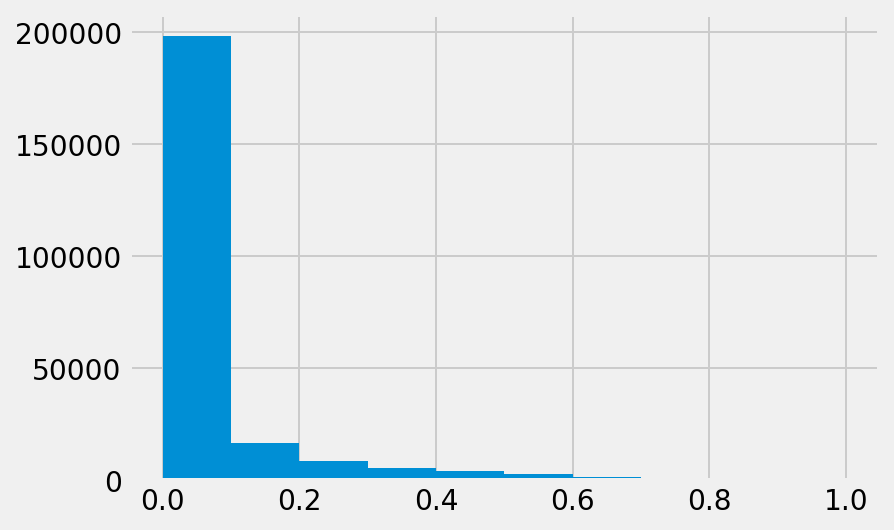

In [14]:
model_df['fire_size_log1_norm'].hist();

#### Cube root

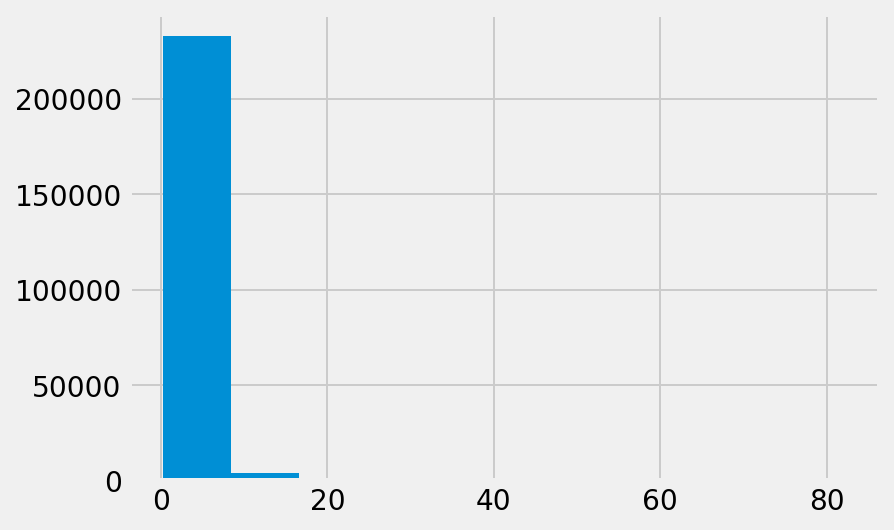

In [15]:
model_df['fire_size_cubert'].hist();

#### Log max

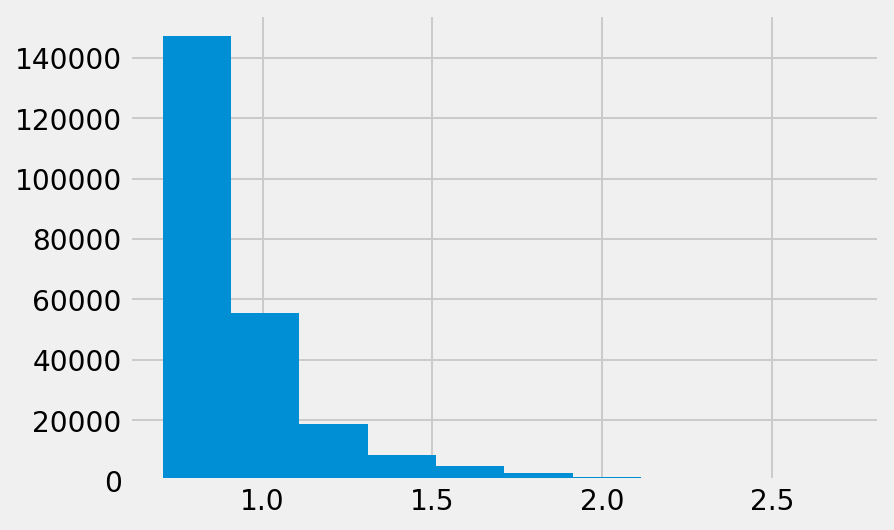

In [16]:
model_df['fire_size_logmax'].hist();

#### Prepare log normal modeling data.

In [17]:
#create X and y variables
X_log = model_df[[ 'pcp', 'tavg', 'pdsi', 'phdi', 'zndx', 'pmdi', 'sp02',
       'sp03', 'sp06', 'sp09', 'sp12', 'sp24', 'tmin', 'tmax', 'month_2', 'month_3',
       'month_4', 'month_5', 'cdd', 'hdd','month_6', 'month_7', 'month_8', 'month_9',
       'month_10', 'month_11', 'month_12', 'cluster_0', 'cluster_1', 'cluster_2',
       'cluster_3', 'cluster_4', 'cluster_5', 'cluster_6', 
       'cluster_7', 'cluster_8', 'cluster_9', 'cluster_10', 'cluster_11',
       'cluster_12', 'cluster_13', 'cluster_14', 'cluster_15', 'cluster_16',
       'cluster_17', 'cluster_18', 'cluster_19', 'cluster_20', 'cluster_21',
       'cluster_22', 'cluster_23', 'cluster_24', 'cluster_25', 'cluster_26',
       'cluster_27', 'cluster_28', 'cluster_29', 'cluster_30', 'cluster_31',
       'cluster_32', 'cluster_33', 'cluster_34', 'cluster_35', 'cluster_36',
       'cluster_37', 'cluster_38', 'cluster_39', 'cluster_40', 'cluster_41',
       'cluster_42', 'cluster_43', 'cluster_44', 'cluster_45', 'cluster_46',
       'cluster_47', 'cluster_48', 'cluster_49', 'cluster_50', 'cluster_51',
       'cluster_52', 'cluster_53', 'cluster_54', 'cluster_55', 'cluster_56',
       'cluster_57', 'cluster_58', 'cluster_59', 'cluster_60', 'cluster_61',
       'cluster_62', 'cluster_63', 'cluster_64', 'cluster_65', 'cluster_66',
       'cluster_67', 'cluster_68', 'cluster_69', 'cluster_70', 'cluster_71',
       'cluster_72', 'cluster_73', 'cluster_74', 'cluster_75', 'cluster_76',
       'cluster_77', 'cluster_78', 'cluster_79', 'cluster_80', 'cluster_81',
       'cluster_82', 'cluster_83', 'cluster_84', 'cluster_85', 'cluster_86',
       'cluster_87', 'cluster_88', 'cluster_89', 'cluster_90', 'cluster_91',
       'cluster_92', 'cluster_93', 'cluster_94', 'cluster_95', 'cluster_96',
       'cluster_97', 'cluster_98', 'cluster_99', 'cluster_100', 'cluster_101',
       'cluster_102', 'cluster_103', 'cluster_104', 'cluster_105',
       'cluster_106', 'cluster_107', 'cluster_108', 'cluster_109',
       'cluster_110', 'cluster_111', 'cluster_112', 'cluster_113',
       'cluster_114', 'cluster_115', 'cluster_116', 'cluster_117',
       'cluster_118', 'cluster_119', 'cluster_120', 'cluster_121',
       'cluster_122', 'cluster_123', 'cluster_124', 'cluster_125',
       'cluster_126', 'cluster_127', 'cluster_128', 'cluster_129',
       'cluster_130', 'cluster_131', 'cluster_132', 'cluster_133',
       'cluster_134', 'cluster_135', 'cluster_136', 'cluster_137',
       'cluster_138', 'cluster_139', 'cluster_140', 'cluster_141',
       'cluster_142', 'cluster_143', 'cluster_144', 'cluster_145',
       'cluster_146', 'cluster_147', 'cluster_148', 'cluster_149',
       'cluster_150', 'cluster_151', 'cluster_152', 'cluster_153',
       'cluster_154', 'cluster_155', 'cluster_156', 'cluster_157',
       'cluster_158', 'cluster_159', 'cluster_160', 'cluster_161',
       'cluster_162', 'cluster_163', 'cluster_164', 'cluster_165',
       'cluster_166', 'cluster_167', 'cluster_168', 'cluster_169',
       'cluster_170', 'cluster_171', 'cluster_172', 'cluster_173',
       'cluster_174', 'cluster_175', 'cluster_176', 'cluster_177',
       'cluster_178', 'cluster_179', 'cluster_180', 'cluster_181',
       'cluster_182', 'cluster_183', 'cluster_184', 'cluster_185',
       'cluster_186', 'cluster_187', 'cluster_188', 'cluster_189',
       'cluster_190', 'cluster_191', 'cluster_192', 'cluster_193',
       'cluster_194', 'cluster_195', 'cluster_196', 'cluster_197',
       'cluster_198', 'cluster_199',
                 'tavg_t12m',
       'tavg_t9m', 'tavg_t6m', 'tavg_t3m', 'pcp_t12m', 'pcp_t9m', 'pcp_t6m',
       'pcp_t3m', 'pmdi_t12m', 'pmdi_t9m', 'pmdi_t6m', 'pmdi_t3m', 'pdsi_t12m',
       'pdsi_t9m', 'pdsi_t6m', 'pdsi_t3m']]
y_log = model_df[['fire_size_log']]

assert len(X_log) == len(y_log)

In [18]:
#split into training and test groups
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(X_log, y_log, random_state = 42, test_size=.2, train_size = .8)

# Models

# Model #1, OLS, not scaled. As baseline for regression.

### Normal

In [19]:
#Instantiate, fit and score 
lr = LinearRegression()
lr.fit(X=X_train, y=y_train)
print(f' Unscaled Linear Regression training R^2 score: {round(lr.score(X=X_train, y=y_train),4)}')
print(f' Unscaled Linear Regression test R^2 score: {round(lr.score(X_test, y_test),4)}')

 Unscaled Linear Regression training R^2 score: 0.0074
 Unscaled Linear Regression test R^2 score: 0.0052


### Log Transform

In [20]:
#Instantiate, fit and score 
lr_log = LinearRegression()
lr_log.fit(X=X_train_log, y=y_train_log)
print(f' Unscaled Linear Regression training R^2 score: {round(lr_log.score(X=X_train_log, y=y_train_log),4)}')
print(f' Unscaled Linear Regression test R^2 score: {round(lr_log.score(X_test_log, y_test_log),4)}')

 Unscaled Linear Regression training R^2 score: 0.1365
 Unscaled Linear Regression test R^2 score: 0.1303


The log transform of the target gives the model a noticeable improvement. I will move forward with evaluation with the log transform fire size as target.

# Model #2, Statsmodel for stastical significance testing

#### Normal

In [21]:
#fit model
X = sm.add_constant(X)
ols = sm.OLS(y, X).fit()

In [22]:
#let's take a quick look at the summary stats of our ordinary least squares
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              fire_size   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     7.132
Date:                Fri, 29 Jan 2021   Prob (F-statistic):          5.80e-221
Time:                        23:37:52   Log-Likelihood:            -2.3482e+06
No. Observations:              238938   AIC:                         4.697e+06
Df Residuals:                  238695   BIC:                         4.699e+06
Df Model:                         242                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -1000.3716    596.444     -1.677      0.093   -2169.387     168.644
pcp            -2.6286     26.351     -0.100      0.921     -54.275      49.018
tavg         -385.4455    265.326     -1.453      0.146    -905.477     134.586
pdsi           -8.5232     12.434     -0.685      0.493     -32.894      15.847
phdi           15.4869     23.443      0.661      0.509     -30.460      61.434
zndx            1.8081     16.077      0.112      0.910     -29.702      33.318
pmdi           -8.2592     27.838     -0.297      0.767     -62.821      46.302
sp02           36.1324     19.732      1.831      0.067      -2.542      74.807
sp03          -76.7522     22.814     -3.364      0.001    -121.468     -32.037
sp06          101.0300     24.088      4.194      0.000      53.818     148.242
sp09         -103.9194     35.713     -2.910      0.004    -173.917     -33.922
sp12           41.1107     36.900      1.114      0.265     -31.212     113.433
sp24           40.3987     23.384      1.728      0.084      -5.433      86.230
tmin          157.8311    133.050      1.186      0.236    -102.944     418.607
tmax          236.3394    133.152      1.775      0.076     -24.636     497.314
month_2       -31.1753    147.564     -0.211      0.833    -320.398     258.047
month_3      -250.8832    159.398     -1.574      0.116    -563.298      61.532
month_4      -364.4300    189.850     -1.920      0.055    -736.531       7.671
month_5      -450.8470    226.662     -1.989      0.047    -895.098      -6.596
cdd            -0.1630      0.223     -0.732      0.464      -0.600       0.274
hdd             0.1433      0.263      0.545      0.586      -0.372       0.659
month_6      -476.8641    252.706     -1.887      0.059    -972.162      18.433
month_7      -481.6173    264.607     -1.820      0.069   -1000.239      37.005
month_8      -463.0731    253.062     -1.830      0.067    -959.068      32.922
month_9      -555.1248    231.044     -2.403      0.016   -1007.965    -102.285
month_10     -258.1798    202.528     -1.275      0.202    -655.130     138.770
month_11     -122.9678    170.456     -0.721      0.471    -457.057     211.121
month_12       31.2858    160.973      0.194      0.846    -284.217     346.789
cluster_0    -234.0220    106.755     -2.192      0.028    -443.258     -24.786
cluster_1     118.1937    107.383      1.101      0.271     -92.275     328.662
cluster_2    -256.2081    111.188     -2.304      0.021    -474.133     -38.283
cluster_3    -132.8399    125.954     -1.055      0.292    -379.707     114.027
cluster_4      39.8658    191.491      0.208      0.835    -335.452     415.184
cluster_5    -201.8501    117.647     -1.716      0.086    -432.435      28.734
cluster_6     -49.7588    156.913     -0.317      0.751    -357.304     257.786
cluster_7     226.1195    156.164      1.44

#### The above shows what we excpect. That certain cluster locations have more significant impact on the explained variance than others. Some places have more fires than other places. These places tend to be more densely forested.

#### Log Transform

In [23]:
#fit model
X = sm.add_constant(X_log)
ols = sm.OLS(y_log, X_log).fit()

In [24]:
#let's take a quick look at the summary stats of our ordinary least squares
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          fire_size_log   R-squared:                       0.136
Model:                            OLS   Adj. R-squared:                  0.135
Method:                 Least Squares   F-statistic:                     154.7
Date:                Fri, 29 Jan 2021   Prob (F-statistic):               0.00
Time:                        23:38:04   Log-Likelihood:            -5.3452e+05
No. Observations:              238938   AIC:                         1.070e+06
Df Residuals:                  238695   BIC:                         1.072e+06
Df Model:                         242                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
pcp             0.0386      0.013      2.896      0.004       0.012       0.065
tavg           -0.0968      0.134     -0.722      0.470      -0.360       0.166
pdsi            0.0218      0.006      3.470      0.001       0.009       0.034
phdi            0.0442      0.012      3.732      0.000       0.021       0.067
zndx           -0.0341      0.008     -4.199      0.000      -0.050      -0.018
pmdi            0.0225      0.014      1.597      0.110      -0.005       0.050
sp02            0.0134      0.010      1.341      0.180      -0.006       0.033
sp03           -0.0867      0.012     -7.525      0.000      -0.109      -0.064
sp06            0.0131      0.012      1.078      0.281      -0.011       0.037
sp09            0.0049      0.018      0.273      0.785      -0.030       0.040
sp12           -0.0296      0.019     -1.590      0.112      -0.066       0.007
sp24            0.0213      0.012      1.803      0.071      -0.002       0.044
tmin           -0.0495      0.067     -0.737      0.461      -0.181       0.082
tmax            0.1267      0.067      1.884      0.060      -0.005       0.259
month_2         0.4341      0.075      5.822      0.000       0.288       0.580
month_3         0.7982      0.081      9.910      0.000       0.640       0.956
month_4         1.0197      0.096     10.630      0.000       0.832       1.208
month_5         1.0379      0.115      9.063      0.000       0.813       1.262
cdd             0.0013      0.000     11.278      0.000       0.001       0.001
hdd          6.299e-05      0.000      0.474      0.635      -0.000       0.000
month_6         1.2286      0.128      9.622      0.000       0.978       1.479
month_7         1.0479      0.134      7.838      0.000       0.786       1.310
month_8         0.9532      0.128      7.455      0.000       0.703       1.204
month_9         0.5924      0.117      5.075      0.000       0.364       0.821
month_10        0.5836      0.102      5.703      0.000       0.383       0.784
month_11        0.4001      0.086      4.646      0.000       0.231       0.569
month_12        0.1202      0.081      1.477      0.140      -0.039       0.280
cluster_0      -3.7868      0.316    -11.996      0.000      -4.406      -3.168
cluster_1      -1.4318      0.298     -4.804      0.000      -2.016      -0.848
cluster_2      -3.7884      0.312    -12.133      0.000      -4.400      -3.176
cluster_3      -3.9110      0.316    -12.381      0.000      -4.530      -3.292
cluster_4      -2.9206      0.321     -9.102      0.000      -3.550      -2.292
cluster_5      -4.1507      0.308    -13.473      0.000      -4.754      -3.547
cluster_6      -3.0928      0.314     -9.839      0.000      -3.709      -2.477
cluster_7      -3.0590      0.306    -10.003      0.000      -3.658      -2.460
cluster_8      -3.4659      0.316    -10.98

#### There is loss in interperability with the log transformed target.

# Model #3, Linear Regression, scaled

#### Normal

In [25]:
sc = StandardScaler()
Z_train = sc.fit_transform(X_train)
Z_test = sc.transform(X_test)

In [26]:
lr_stan = LinearRegression()
lr_stan.fit(Z_train, y_train)
print(f' Scaled Linear Regression training R^2 score: {round(lr_stan.score(Z_train, y_train),4)}')
print(f' Scaled Linear Regression test R^2 score: {round(lr_stan.score(Z_test, y_test),4)}')

 Scaled Linear Regression training R^2 score: 0.0074
 Scaled Linear Regression test R^2 score: 0.0052


##### There is no noteable change in R^2 after scaling. Feature scale may not be an issue.

#### Log Transform

In [27]:
sc = StandardScaler()
Z_train = sc.fit_transform(X_train_log)
Z_test = sc.transform(X_test_log)

In [28]:
lr_stan = LinearRegression()
lr_stan.fit(Z_train, y_train_log)
print(f' Scaled Linear Regression training R^2 score: {round(lr_stan.score(Z_train, y_train_log),4)}')
print(f' Scaled Linear Regression test R^2 score: {round(lr_stan.score(Z_test, y_test_log),4)}')

 Scaled Linear Regression training R^2 score: 0.1365
 Scaled Linear Regression test R^2 score: 0.1303


# Model #4, Lasso Gridsearch, basic

#### Normal

In [29]:
lasso_pipe = Pipeline([
    ('sc', StandardScaler()),
    ('lassocv', Lasso())
])

In [35]:
lasso = Lasso(max_iter=1000)

In [38]:
#set up lasso parameters to use grid search
lasso_params = {'alpha':np.logspace(0, 3, 1000)}

# we use gridsearch instead of LassoCV to take advantage of multiple cores
lasso_gridsearch = GridSearchCV(estimator = lasso,
                                param_grid = lasso_params,
                                verbose = 2,
                                cv = 5,
                                scoring = 'r2',
                                n_jobs = -1)

In [ ]:
lasso_gridsearch.fit(X_train, y_train)
lasso_gridsearch.best_estimator_

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


In [ ]:
# BEST PARAMS
# Pipeline(memory=None,
#          steps=[('sc',
#                  StandardScaler(copy=True, with_mean=True, with_std=True)),
#                 ('lassocv',
#                  Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
#                        max_iter=10000, normalize=False, positive=False,
#                        precompute=False, random_state=None, selection='cyclic',
#                        tol=0.0001, warm_start=True))],
#          verbose=False)

##### Coef_ eval

In [ ]:
lasso_sc = StandardScaler()
lasso_Z_train = lasso_sc.fit_transform(X_train)
lasso_Z_test = lasso_sc.fit_transform(X_test)

In [ ]:
lasso_coef_eval = Lasso(alpha = 1, max_iter=10000)

In [ ]:
print(lasso_Z_train.shape)
print(y_train.shape)

In [ ]:
lasso_coef_eval.fit(lasso_Z_train, y_train)
print(f'Lasso R^2 Cross Validated Score: {round(cross_val_score(lasso_coef_eval, lasso_Z_train, y_train).mean(),4)}') 

In [ ]:
lasso_coef_eval.intercept_

In [ ]:
feature_importance = pd.DataFrame(list(zip(X_train.columns, lasso_coef_eval.coef_)))
feature_importance

#### Log Transform

In [ ]:
lasso_pipe = Pipeline([
    ('sc', StandardScaler()),
    ('lassocv', Lasso())
])

In [ ]:
lasso_params = {'lassocv__alpha':np.logspace(0, 3, 1000),
               'lassocv__max_iter':[1000],
               }

In [ ]:
%%time
lasso_pipe_gridsearch = GridSearchCV(lasso_pipe, 
                                param_grid=lasso_params,
                                verbose = 2,
                                #cv = 5,
                                scoring = 'r2',
                                n_jobs = -1
                                )

In [ ]:
%%time
lasso_pipe_gridsearch.fit(X_train_log, y_train_log)

In [ ]:
lasso_pipe_gridsearch.best_estimator_

##### Coef_eval

In [ ]:
lasso_sc = StandardScaler()
lasso_Z_train = lasso_sc.fit_transform(X_train_log)
lasso_Z_test = lasso_sc.fit_transform(X_test_log)

In [ ]:
lasso_coef_eval = Lasso(alpha = 1, max_iter=10000)

In [ ]:
print(lasso_Z_train.shape)
print(y_train_log.shape)

In [ ]:
lasso_coef_eval.fit(lasso_Z_train, y_train_log)
print(f'Lasso R^2 Cross Validated Score: {round(cross_val_score(lasso_coef_eval, lasso_Z_train, y_train_log).mean(),4)}') 

In [ ]:
lasso_coef_eval.intercept_

In [ ]:
feature_importance = pd.DataFrame(list(zip(X_train_log.columns, lasso_coef_eval.coef_)))
feature_importance
# The L1 penalty is not kind.

# Model #5, RidgeCV, L1 penalty is not kind to our model. Trying L2.

#### Log Transform

Exploring L2. If I like L2 I will run RidgeCV for polynomial features

In [ ]:
%%time
# Set up a list of ridge alphas to check.
# np.logspace generates 100 values equally between 0 and 5,
# then converts them to alphas between 10^0 and 10^5.
r_alphas = np.logspace(0, 5, 100)

# Cross-validate over our list of ridge alphas.
ridge_cv = RidgeCV(alphas=r_alphas, scoring='r2', cv=5)

# Fit model using best ridge alpha!
ridge_cv.fit(Z_train, y_train_log);

In [ ]:
# Here is the optimal value of alpha
alpha = ridge_cv.alpha_
print(alpha)

In [ ]:
print(f' RidgeCV Regression training R^2 score: {round(ridge_cv.score(Z_train, y_train_log),4)}')
print(f' RidgeCV Regression test R^2 score: {round(ridge_cv.score(Z_test, y_test_log),4)}')

#### Coef_eval

In [ ]:
ridge = Ridge(alpha = 0.1, normalize = True, max_iter = 5000)

In [ ]:
# Fit model using best ridge alpha!
ridge.fit(Z_train, y_train_log);

In [ ]:
ridge.coef_

# Model #6, Elastic-Search Gridsearch, Exploring Polynomial Features

#### Log Transform

In [ ]:
pipe_mario = Pipeline([
            ('poly', PolynomialFeatures(degree=2)),
            ('sc', StandardScaler()),
            ('elasticnet', ElasticNet())
                        ])

In [ ]:
parameters_mario = {'elasticnet__alpha': np.logspace(0, 4, 500),
                      'elasticnet__normalize': [True, False],
                      'elasticnet__selection': ['cyclic', 'random'],
                        'elasticnet__max_iter': [10000],
                        #'elasticnet__tol': [.1]
                       }

In [ ]:
elastic_net_model = GridSearchCV(
                pipe_mario, 
                param_grid= parameters_mario,
                verbose = 2,
                #cv = 5,
                scoring = 'r2',
                n_jobs = -1
                )
elastic_net_model.fit(X_train_log, y_train_log)
elastic_net_model.best_estimator_

In [ ]:
print(f'ElasticNet Model R^2 Score: {round(elastic_net_model.best_score_,4)}')

In [ ]:
pipe_mario_ridge = Pipeline([
            ('poly', PolynomialFeatures(degree=2)),
            ('sc', StandardScaler()),
            ('ridge', RidgeCV())
                        ])

In [ ]:
parameters_mario_ridge = {#'ridge__alphas': [1],
                      #'ridge__normalize': [True, False],
                      #'ridge__selection': ['cyclic', 'random'],
                        #'ridge__max_iter': [10000],
                        #'elasticnet__tol': [.1]
                       }

In [ ]:
elastic_net_model = GridSearchCV(
                pipe_mario_ridge, 
                param_grid= parameters_mario_ridge,
                verbose = 2,
                #cv = 5,
                scoring = 'r2',
                n_jobs = -1
                )
elastic_net_model.fit(X_train_log, y_train_log)
elastic_net_model.best_estimator_

### With polynomial features = 2

In [ ]:
trans = PolynomialFeatures(degree=2)
data_train_trans = trans.fit_transform(X_train)
data_test_trans = trans.fit_transform(X_test)

In [ ]:
ridge_poly = Ridge()

In [ ]:
ridge_poly.fit(X=data_train_trans, y=y_train_log)

In [ ]:
ridge_poly.score(X=data_train_trans, y=y_train_log)

In [ ]:
ridge_poly.score(X=data_test_trans, y=y_test_log)